In [3]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
from funcs import *
from robotClass import *

import time
import numpy as np
import matplotlib.pyplot as plt
import asyncio

LOG.propagate = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Lab 7
***KF essentially interpolates ToF Sensor Data***


In [ ]:
# Setup robot
rc = setupRobot()

*Step response*

In [ ]:
# Ping robot to start writing PWM values to the characteristic
rc.pingRobot()

# Wait one second
await asyncio.sleep(1)

# Apply a constant PWM signal for enough time to reach steady state (constant speed)
rc.move_forward([100, 100], 1, 0) # PWM: 100, 1: forward, 0: no PID (no PWM adjustment)
await asyncio.sleep(5) # start with 5 seconds but make it longer if needed
rc.stop()
await asyncio.sleep(2)

# Ping robot to stop writing PWM values to the characteristic
rc.pingRobot()

In [7]:
# Get front ToF sensor output
frontTOFData = processRunData('trial100.txt')#rc.tof2_readings

# Get speed data
# format: [ [velocities], [times] ]
speedData = distToVelocity(frontTOFData)

# Get motor PWM input
#motorData = rc.motor_readings

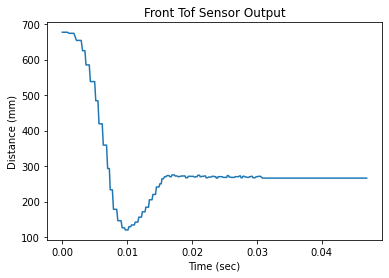

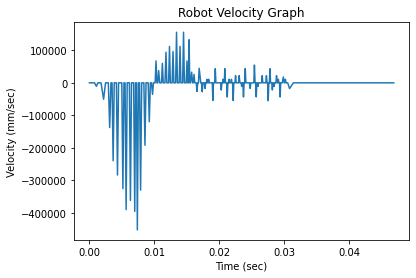

In [18]:
# Plot all three ---

# Front ToF Sensor Output
plotTOFData = dataForPlot(frontTOFData)

plt.plot(plotTOFData[1], plotTOFData[0])
plt.title('Front Tof Sensor Output')
plt.xlabel('Time (sec)')
plt.ylabel('Distance (mm)')
plt.show()

# Speed data
plt.plot(speedData[1], speedData[0])
plt.title('Robot Velocity Graph')
plt.xlabel('Time (sec)')
plt.ylabel('Velocity (mm/sec)')
plt.show()

# Motor data
plotMotorData = dataForPlot(motorData)
plt.plot(plotMotorData[1], plotMotorData[0])
plt.title('PWM Input Graph')
plt.xlabel('Time (sec)')
plt.ylabel('PWM Signal Input')
plt.show()

In [ ]:
# Store the data
trial = 200
storeData(frontTOFData, f'{trial}_TOFData.txt')
storeData(motorData, f'{trial}_motorData.txt')

In [ ]:
# Obtain the steady state speed and 90% rise time from the graphs

Re-obtain PID results

In [41]:
rc.updatePID(300, 0.35, 0.00001, 0.75)

# Ping robot to start writing PWM values to the characteristic
rc.pingRobot()

# Wait one second
await asyncio.sleep(1)

# Apply a constant PWM signal for enough time to reach steady state (constant speed)
rc.move_forward([75, 75], 1, 0) # starting PWM: 75, 1: forward, 1: PID (with PWM adjustment)
await asyncio.sleep(10)
rc.stop()
await asyncio.sleep(2)

# Ping robot to stop writing PWM values to the characteristic
rc.pingRobot()

In [4]:
# A = [ 
#         [ 0    1   ]
#         [ 0   -d/m ]
#     ]
    
# B = [ 
#         0
#         1/m
#     ]

# C = [ 1 0 ]

***For these parts, plot the PWM step function (PWM vs. time), front ToF sensor distance vs. time and speed vs. time***

-Find d: At steady state (constant speed), we can find d = u / x dot

    -u is the PWM signal value
        -Since we're analying the unit step response, we scale this to 1 for now (we are supposed to use the max PWM value from lab 6)
    -x dot is the steady state speed
    
    ***d = 1 / steady state speed
    
    -Lecture example:
        -Steady state speed: 2000 mm/s 


-Find m:
    
    -Find the 90% rise time
    
    -m = (-d * t_0.9) / ln(1-0.9)
   
-dt: time between samples

***We did initial analysis by setting u=1, so later scale down the PWM signal value by dividing it by the max value
    -Ex: if the max was 120, then one of the KF input arguments should be motor PWM/120***

In [5]:
# u is the input (PWM signal)
# x dot is velocity
# d = u / x dot --- when the robot is moving at a constant speed
    # u might need to be the PWM motor value scaled down to [0..1]

# m = (-d * t_90%) / ln(1 - 0.9)

# A = np.array([ [0, 1], [0, -d/m] ])
# B = np.array([ 0, 1/m ])

# sigma values
# sigma_1 and sigma_2: process noise - trust in modeled position (sigma 1) and speed (sigma 2)
    # start with sigma1 = 35 mm and sigma2 = 71 mm/s (or 30 mm/s)
        # Every time the robot travels for 1 second, the ToF measurement is 35 mm off
            # Correlated with how fast the robot runs - use smaller values are larger speeds
# sigma_4: measurement noise --- LARGER VALUE MEANS THERE IS MORE SENSOR ERROR (trusts the sensor data less)
    # error of the sensor: 10-30 mm
    # sigma4 = square root of value in 10-30

In [ ]:
sig_u=np.array([[sigma_1**2,0],[0,sigma_2**2]]) # We assume uncorrelated noise, therefore a diagonal matrix works.
sig_z=np.array([[sigma_4**2]])